In [1]:
# general
import os
import glob
import datetime as dt
import json
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.basemap import Basemap
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from PIL import Image
from matplotlib.animation import PillowWriter, FFMpegWriter
# helper tools
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()
# stats
import scipy.stats as stats
import seaborn as sns
import shapely.geometry as shp

In [2]:
# get the coordingates of Grand Junction, CO
gj = shp.Point(-108.5506, 39.0639)
# get the coordinates of Gothic, CO
gothic = shp.Point(-106.9898, 38.9592)
line = shp.LineString([gj, gothic])


In [3]:
def calc_valley_aligned_wind_speed(wind_speed, wind_dir, valley_alignment):
    """
    Calculate the valley aligned wind speed
    """
    # calculate the angle between the wind direction and the valley alignment
    angle = np.abs(wind_dir - valley_alignment)
    # calculate the valley aligned wind speed
    valley_aligned_wind_speed = wind_speed * np.cos(np.radians(angle))
    return valley_aligned_wind_speed

# create some tests to make sure the function works
calc_valley_aligned_wind_speed(10,315,270)

7.0710678118654755

In [8]:
ds = xr.open_mfdataset('/storage/dlhogan/data/processed_data/*.nc', chunks={'valid_time': 100, 'longitude':10, "latitude":10})
winter_2022 = slice('2021-12-01T00:00:00', '2022-03-31T23:00:00')
winter_2023 = slice('2022-12-01T00:00:00', '2023-03-31T23:00:00')

valley_orientation = 305
cross_valley_orientation = 215
def subset_ds(ds, winter_slice):
    # subset the data   
    ds_subset = ds.sel(valid_time=winter_slice)
    ds_subset = ds_subset.sel(longitude=gothic.x, latitude=gothic.y, method='nearest').compute()

    # calculate the wind speed and direction
    ds_subset['wind_speed'] = np.sqrt(ds_subset.u**2 + ds_subset.v**2)
    # create a column with the wind direction
    ds_subset['wind_dir'] = np.arctan2(ds_subset['v'], ds_subset['u']) * 180 / np.pi
    # convert wind direction to compass direction
    ds_subset['wind_dir'] = (270 - ds_subset['wind_dir']) % 360
    ds_subset['valley_component_wind_speed'] = np.abs(calc_valley_aligned_wind_speed(ds_subset['wind_speed'], ds_subset['wind_dir'], valley_orientation))
    ds_subset['cross_valley_component_wind_speed'] = np.abs(calc_valley_aligned_wind_speed(ds_subset['wind_speed'], ds_subset['wind_dir'], cross_valley_orientation))
    # calculate dew point from relative humidity and temeprature
    # convert temperature to celsius
    ds_subset['t'] = units.units('degC') * (ds_subset['t']-273.15)
    return ds_subset

ds_winter_2022 = subset_ds(ds, winter_2022)
ds_winter_2023 = subset_ds(ds, winter_2023)

/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/xarray/core/dataset.py:278: UserWarning:

The specified chunks separate the stored chunks along dimension "valid_time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.

/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/xarray/core/dataset.py:278: UserWarning:

The specified chunks separate the stored chunks along dimension "latitude" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.

/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/xarray/core/dataset.py:278: UserWarning:

The specified chunks separate the stored chunks along dimension "longitude" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.

/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/xarray/core/dataset.py:278: UserWarning:

In [9]:
# take in sublimation data
latent_heat_flux_2022 = pd.read_csv('./01_data/processed_data/sublimation/w22_latent_heat_flux_splash_ap.csv', index_col=0, parse_dates=True)
latent_heat_flux_2023 = pd.read_csv('./01_data/processed_data/sublimation/w23_latent_heat_flux_3m.csv', index_col=0, parse_dates=True)

In [10]:
# open large and spiky events dataset 
w22_large_sublimation_long_events = pd.read_csv('./01_data/processed_data/sublimation/w22_large_sublimation_long_events.csv', index_col=0, parse_dates=True)
w22_large_sublimation_spiky_events = pd.read_csv('./01_data/processed_data/sublimation/w22_large_sublimation_spiky_events.csv', index_col=0, parse_dates=True)
w23_large_sublimation_long_events = pd.read_csv('./01_data/processed_data/sublimation/w23_large_sublimation_long_events.csv', index_col=0, parse_dates=True)
w23_large_sublimation_spiky_events = pd.read_csv('./01_data/processed_data/sublimation/w23_large_sublimation_spiky_events.csv', index_col=0, parse_dates=True)

In [44]:
# open precipitation data
w22_precipitation = pd.read_csv('./01_data/processed_data/precipitation/w22_all_precip_30min.csv', index_col=0, parse_dates=True)['SAIL_gts_pluvio'].loc['2021-12-01':'2022-03-31']
w23_precipitation = pd.read_csv('./01_data/processed_data/precipitation/w23_all_precip_30min.csv', index_col=0, parse_dates=True)['SAIL_gts_pluvio'].loc['2022-12-01':'2023-03-31']

In [147]:
# # resample to daily
# w22_large_sublimation_long_events = w22_large_sublimation_long_events.resample('D').sum()
# w22_large_sublimation_spiky_events = w22_large_sublimation_spiky_events.resample('D').sum()
# w23_large_sublimation_long_events = w23_large_sublimation_long_events.resample('D').sum()
# w23_large_sublimation_spiky_events = w23_large_sublimation_spiky_events.resample('D').sum()

# # drop values that are zero
# w22_large_sublimation_long_events = w22_large_sublimation_long_events[w22_large_sublimation_long_events['splash_ap'] > 0]
# w22_large_sublimation_spiky_events = w22_large_sublimation_spiky_events[w22_large_sublimation_spiky_events['splash_ap'] > 0]
# w23_large_sublimation_long_events = w23_large_sublimation_long_events[w23_large_sublimation_long_events['sos_3m'] > 0]
# w23_large_sublimation_spiky_events = w23_large_sublimation_spiky_events[w23_large_sublimation_spiky_events['sos_3m'] > 0]


In [45]:
def select_data(lh_df, ppt_data, reanalysis_ds, short_events, long_events):
    """
    This function will provide the necessary data for the analysis of sublimation events in relation to the reanalysis data.
    """
    # resample latent heat flux data and precipitation data to 3H
    lh_df_3H = lh_df.resample('3H').mean()
    ppt_data_3H = ppt_data.resample('3H').sum()
    #   filter out exrtreme values
    lh_df_3H = lh_df_3H.where(lh_df_3H >-50, np.nan)
    # select the reanalysis pressure level
    ds = reanalysis_ds.sel(pressure_level=500).resample(valid_time='3H').median()

    return lh_df_3H, ppt_data_3H, ds, short_events, long_events

In [51]:
def plot_surface_and_reanalysis_vars(lh_df, ppt_data, era5_ds, short_events, long_events, lh_var, reanalysis_var1, reanalysis_var2):
    """
    This function will plot the relationship between the latent heat flux and the reanalysis variables.
    Inputs:
    lh_df: DataFrame with the latent heat flux data
    ppt_data: DataFrame with the precipitation data
    era5_ds: xarray dataset with the reanalysis data
    short_events: DataFrame with the short, intense sublimation events
    long_events: DataFrame with the long sublimation events
    lh_var: string with the name of the latent heat flux variable
    reanalysis_var1: string with the name of the first reanalysis variable
    reanalysis_var2: string with the name of the second reanalysis variable
    """
    lh_df, ppt_data, era5_ds, short_events, long_events = select_data(lh_df, ppt_data, era5_ds, short_events, long_events)

    xlabel_dict = {'u': 'Wind Speed (m/s)', 
                   'v': 'Wind Speed (m/s)', 
                   't': 'Temperature (C)', 
                   'q': 'Specifc Humidity (kg/kg)', 
                   'wind_speed': 'Wind Speed (m/s)', 
                   'wind_dir': 'Wind Direction (degrees)',
                   'valley_component_wind_speed': 'Valley Component Wind Speed (m/s)',
                   'cross_valley_component_wind_speed': 'Cross Valley Component Wind Speed (m/s)',}
    xlims_dict = {
             'q': (0, 0.0035),
             't': (-40, -5),}
             
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    ax = axs[0]
    ax.scatter(era5_ds[reanalysis_var1], lh_df[lh_var])
    # ax.set_xlabel('Wind Speed')
    ax.set_ylabel('Daily Average Latent Heat Flux (W/m^2)')
    if reanalysis_var1 in xlims_dict.keys():
            ax.set_xlim(xlims_dict[reanalysis_var1])

    # add edge color around the large sublimation events 
    ax.scatter(era5_ds.sel(valid_time=long_events.index)[reanalysis_var1], lh_df.loc[long_events.index][lh_var], c="black", edgecolors='black')
    ax.scatter(era5_ds.sel(valid_time=ppt_data[ppt_data>1].index)[reanalysis_var1], lh_df.loc[ppt_data[ppt_data>1].index][lh_var], c="red", edgecolors='red', label='Precipitation')
    ax.set_xlabel(xlabel_dict[reanalysis_var1])
    ax.axvline(28, color='black', linestyle='--')
    
    ax = axs[1]
    ax.scatter(era5_ds[reanalysis_var2], lh_df[lh_var])
    ax.scatter(era5_ds.sel(valid_time=long_events.index)[reanalysis_var2], lh_df.loc[long_events.index][lh_var], c="black", edgecolors='black', label='Long Events')
    ax.axvline(33, color='black', linestyle='--')
    ax.scatter(era5_ds.sel(valid_time=ppt_data[ppt_data>1].index)[reanalysis_var2], lh_df.loc[ppt_data[ppt_data>1].index][lh_var], c="red", edgecolors='red', label='Precipitation')
    ax.set_xlabel(xlabel_dict[reanalysis_var2])
    ax.set_ylabel('Daily Average Latent Heat Flux (W/m^2)')
    ax.legend()
    if reanalysis_var2 in xlims_dict.keys():
            ax.set_xlim(xlims_dict[reanalysis_var2])
    # add colorbar
    # plt.colorbar(ax.collections[0], ax=axs, orientation='horizontal', label='500 mb Temperature (C)')

    for ax in axs:
        ax.set_ylim(-10, lh_df[lh_var].max()+10)
    return fig

Text(0.5, 0.98, '2023')

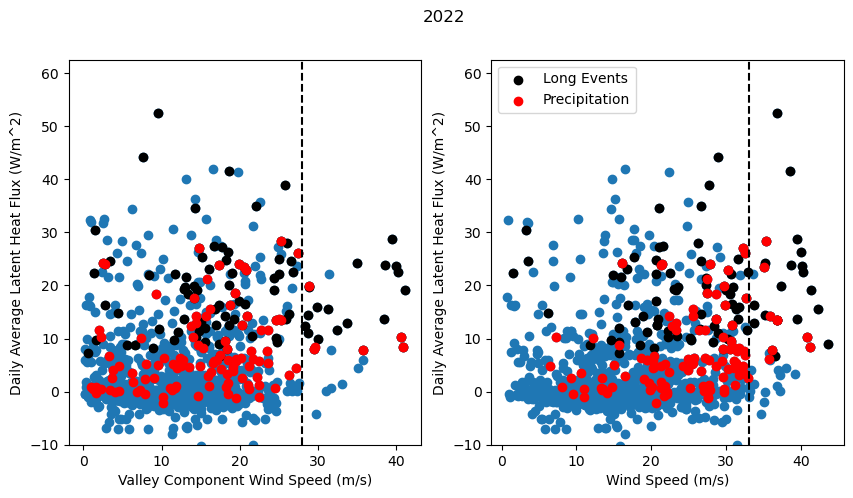

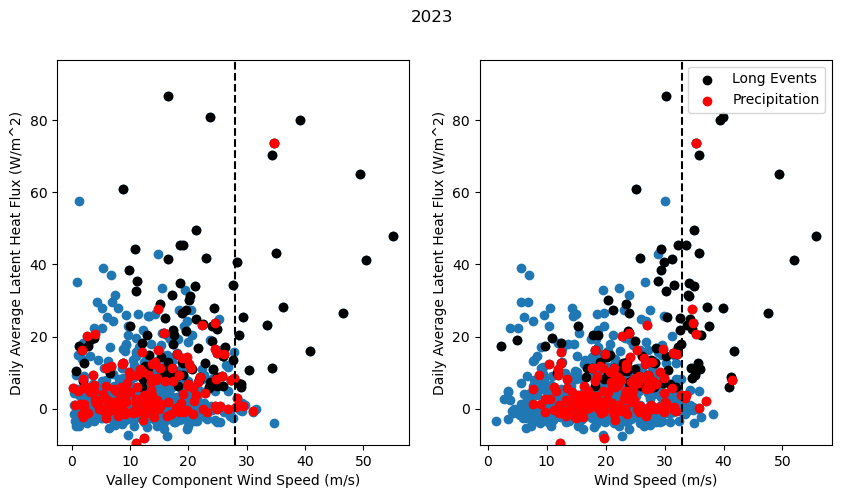

In [56]:
fig = plot_surface_and_reanalysis_vars(latent_heat_flux_2022, w22_precipitation, ds_winter_2022, w22_large_sublimation_spiky_events, w22_large_sublimation_long_events, 'splash_ap', 'valley_component_wind_speed', 'wind_speed')
fig.suptitle('2022')
fig = plot_surface_and_reanalysis_vars(latent_heat_flux_2023, w23_precipitation, ds_winter_2023, w23_large_sublimation_spiky_events, w23_large_sublimation_long_events, 'sos_3m', 'valley_component_wind_speed', 'wind_speed')
fig.suptitle('2023')

Text(0.5, 0.98, '2023')

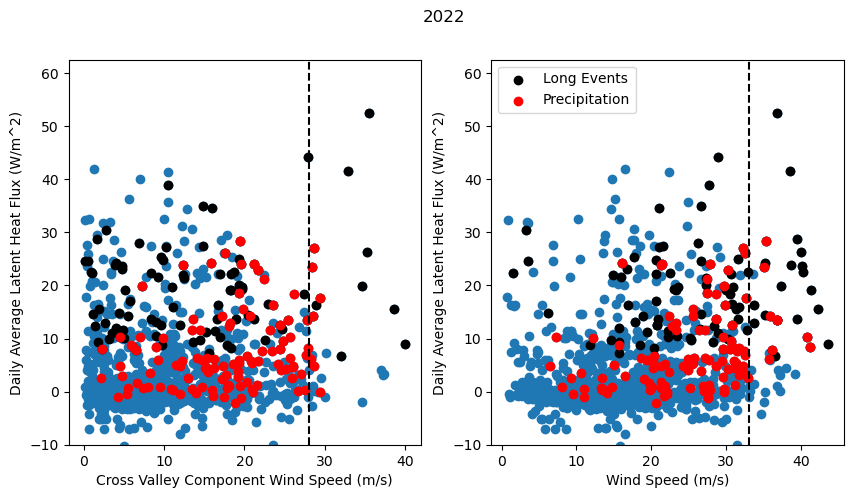

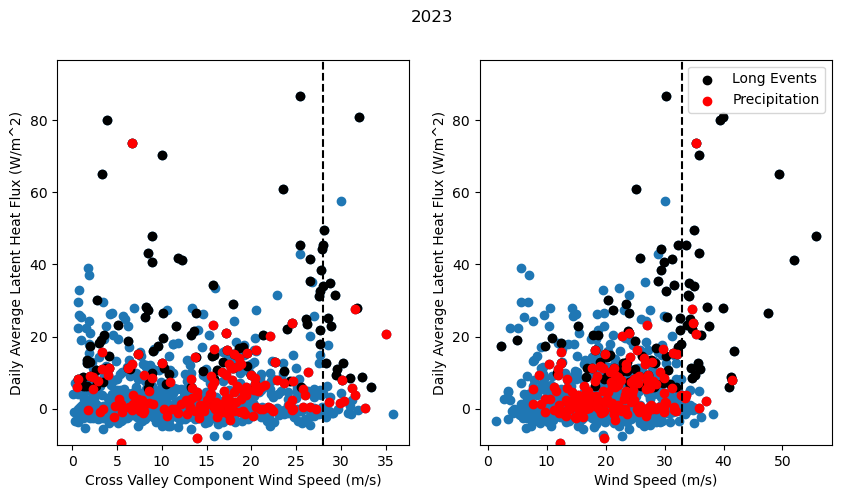

In [58]:
fig = plot_surface_and_reanalysis_vars(latent_heat_flux_2022, w22_precipitation, ds_winter_2022, w22_large_sublimation_spiky_events, w22_large_sublimation_long_events, 'splash_ap', 'cross_valley_component_wind_speed', 'wind_speed')
fig.suptitle('2022')
fig = plot_surface_and_reanalysis_vars(latent_heat_flux_2023, w23_precipitation, ds_winter_2023, w23_large_sublimation_spiky_events, w23_large_sublimation_long_events, 'sos_3m', 'cross_valley_component_wind_speed', 'wind_speed')
fig.suptitle('2023')

In [69]:
lh_df, ppt_data, era5_ds, short_events, long_events = select_data(latent_heat_flux_2023, w23_precipitation, ds_winter_2023, w23_large_sublimation_spiky_events, w23_large_sublimation_long_events,)

In [74]:
ppt_data.loc[long_events.index].values

array([5.81      , 4.26      , 4.5700002 , 0.57      , 0.        ,
       0.        , 0.        , 0.14      , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.97000003, 0.47      , 1.41999997, 0.77      , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.96      , 2.08      , 0.        , 0.        ,
       0.        , 1.1       , 0.45999999, 0.        , 0.        ,
       0.        , 1.18      , 1.86      , 0.        , 0.        ,
       2.17000002, 1.98999999, 2.3       , 3.57      , 1.28000002,
       0.34      , 1.        , 0.18      , 0.89      , 0.14      ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [76]:
wind_threshold = 34
high_vals = (era5_ds['wind_speed']>wind_threshold) &  (era5_ds['q']<0.0015) & (ppt_data<=1)
# low vals 
low_vals = ~high_vals

high_vals_during_large_events = ((era5_ds.sel(valid_time=long_events.index)['wind_speed']>=wind_threshold) &
                                (era5_ds.sel(valid_time=long_events.index)['q']<0.0015)
                                )
low_vals_during_large_events = ~high_vals_during_large_events

# make a confusion matrix 
confusion_matrix = pd.DataFrame(index=['Low Wind Speed', 'High Wind Speed'], columns=['Event', 'Non-Event'])
confusion_matrix.loc['Low Wind Speed', 'Event'] = low_vals_during_large_events.sum().item()
confusion_matrix.loc['Low Wind Speed', 'Non-Event'] = (low_vals.sum() - low_vals_during_large_events.sum()).item()
confusion_matrix.loc['High Wind Speed', 'Event'] = high_vals_during_large_events.sum().item()
confusion_matrix.loc['High Wind Speed', 'Non-Event'] = (high_vals.sum() - high_vals_during_large_events.sum()).item()

confusion_matrix


,Event,Non-Event
Low Wind Speed,81,853
High Wind Speed,30,4


Text(0.5, 0.98, '2023')

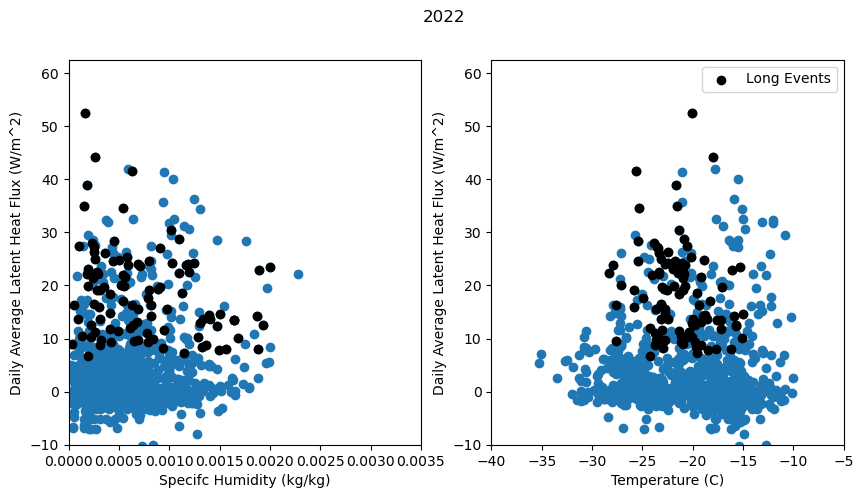

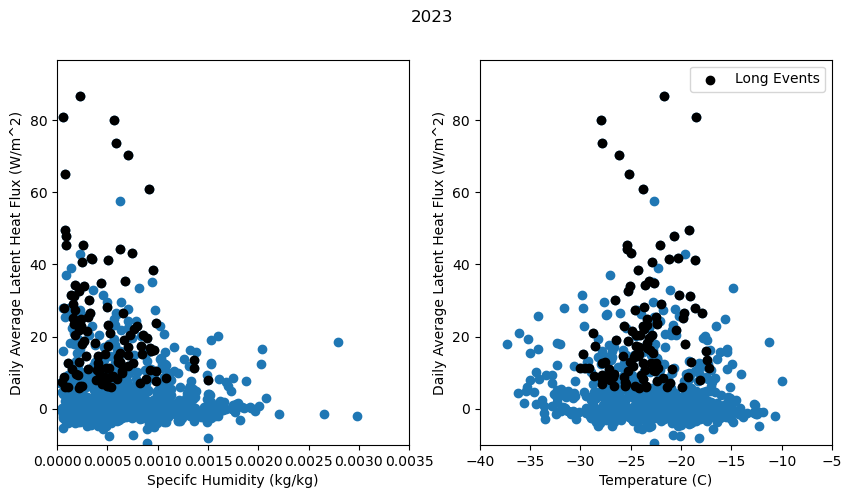

In [28]:
fig = plot_surface_and_reanalysis_vars(latent_heat_flux_2022, ds_winter_2022, w22_large_sublimation_spiky_events, w22_large_sublimation_long_events, 'splash_ap', 'q', 't')
fig.suptitle('2022')
fig = plot_surface_and_reanalysis_vars(latent_heat_flux_2023, ds_winter_2023, w23_large_sublimation_spiky_events, w23_large_sublimation_long_events, 'sos_3m', 'q', 't')
fig.suptitle('2023')

In [171]:
# merge the two datasets
if 'splash_ap' in latent_heat_flux_2022.columns:
    latent_heat_flux_2022.rename(columns={'splash_ap': 'sublimation'}, inplace=True)
if 'sos_3m' in latent_heat_flux_2023.columns:
    latent_heat_flux_2023.rename(columns={'sos_3m': 'sublimation'}, inplace=True)
latent_heat_flux = pd.concat([latent_heat_flux_2022, latent_heat_flux_2023], axis=0)

# merge the two datasets
reanalysis_df = xr.merge([ds_winter_2022, ds_winter_2023]).sel(pressure_level=500).to_dataframe()[['u','v', 't','q','wind_speed','wind_dir','valley_component_wind_speed']]

combined_df = pd.merge(latent_heat_flux, reanalysis_df, left_index=True, right_index=True).dropna(how='any')

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # For regression tasks

# Step 2: Load your dataframe (replace 'df' with your actual dataframe)
# Example assuming 'df' is your dataframe containing predictors (X) and target (y)
# Replace 'predictor_col1', 'predictor_col2', etc. with your actual predictor columns
# Replace 'target_col' with your actual target column name
X = combined_df[['wind_speed','q','t']]
y = combined_df['sublimation']

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Create a random forest regressor model
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)

# Step 5: Train the model on the training data
rf_model.fit(X_train, y_train)

# Step 6: Evaluate the model
# Assess performance on the test set (you can use different metrics depending on your problem)
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print(f"Training R^2 score: {train_score:.2f}")
print(f"Testing R^2 score: {test_score:.2f}")
# evaluate with mean squared error
from sklearn.metrics import mean_squared_error
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")


# Step 7: Assess feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
sorted_importances = feature_importances.sort_values('importance', ascending=False)
print(sorted_importances)

Training R^2 score: 0.89
Testing R^2 score: 0.20
Mean Squared Error: 121.68
      feature  importance
0  wind_speed    0.395681
2           t    0.321141
1           q    0.283178


In [187]:
# visualize a tree
from sklearn.tree import export_graphviz

fn=X.columns
cn=['sublimation']

str_tree = export_graphviz(rf_model.estimators_[0],
                feature_names=X.columns,
   filled=True,        
   special_characters=True, 
   rotate=True)


In [34]:
def clippedcolorbar(CS, **kwargs):
    from matplotlib.cm import ScalarMappable
    from numpy import arange, floor, ceil
    fig = CS.get_figure()
    vmin = CS.get_clim()[0]
    vmax = CS.get_clim()[1]
    m = ScalarMappable(cmap=CS.get_cmap())
    m.set_array(CS.get_array())
    m.set_clim(CS.get_clim())
    step = CS.levels[1] - CS.levels[0]
    cliplower = CS.zmin<vmin
    clipupper = CS.zmax>vmax
    noextend = 'extend' in kwargs.keys() and kwargs['extend']=='neither'
    # set the colorbar boundaries
    boundaries = arange((floor(vmin/step)-1+1*(cliplower and noextend))*step, (ceil(vmax/step)+1-1*(clipupper and noextend))*step, step)
    kwargs['boundaries'] = boundaries
    # if the z-values are outside the colorbar range, add extend marker(s)
    # This behavior can be disabled by providing extend='neither' to the function call
    if not('extend' in kwargs.keys()) or kwargs['extend'] in ['min','max']:
        extend_min = cliplower or ( 'extend' in kwargs.keys() and kwargs['extend']=='min' )
        extend_max = clipupper or ( 'extend' in kwargs.keys() and kwargs['extend']=='max' )
        if extend_min and extend_max:
            kwargs['extend'] = 'both'
        elif extend_min:
            kwargs['extend'] = 'min'
        elif extend_max:
            kwargs['extend'] = 'max'
    return fig.colorbar(m, **kwargs)

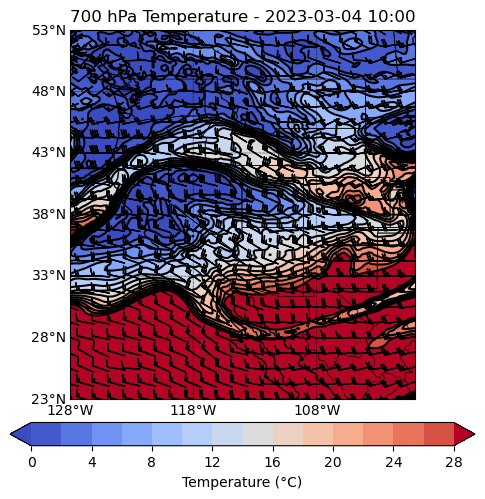

In [35]:
# create Pillow writer object
metadata = dict(title='ERA5 700 hPa Temperature', artist='DLHogan')
writer = PillowWriter(fps=3, metadata=metadata,)

# Create the figure and basemap
fig = plt.figure(figsize=(6, 6))


# with writer.saving(fig, "temperature.gif", 100):
for i,t in enumerate(ds_subset_700['time'][10:11]):
    # clear the figure
    plt.clf()
    m = Basemap(projection='cyl', llcrnrlon=-128, llcrnrlat=23, urcrnrlon=-100, urcrnrlat=53, resolution='l')
    m.drawcoastlines(1)
    m.drawcountries()

    # Draw parallels and meridians
    parallels = np.arange(23, 53 + 0.25, 5)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5)
    meridians = np.arange(-128, -100 + 0.25, 10)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5)
    m.drawstates()
    # Contour plot for temperature
    cbarticks=np.arange(0.0,30.0,2)
    cf = plt.contourf(ds_subset_700['longitude'], ds_subset_700['latitude'], (ds_subset_700['t'].sel(time=t).to_numpy() - ds_subset_700['dew_point'].sel(time=t).to_numpy()), cbarticks, cmap='coolwarm', vmin=0, vmax=30, extend='both')
    c = plt.contour(ds_subset_700['longitude'], ds_subset_700['latitude'], (ds_subset_700['t'].sel(time=t).to_numpy() - ds_subset_700['dew_point'].sel(time=t).to_numpy()), cbarticks, colors='k')
    cb = fig.colorbar(cf, orientation='horizontal', pad=0.05, label='Temperature (°C)')

    # add title of the time
    plt.title(f'700 hPa Temperature - {ds_subset_700["time"].sel(time=t).dt.strftime("%Y-%m-%d %H:%M").item()}')
    # Add barbs for wind, showing every 10th barb
    lon, lat = np.meshgrid(ds_subset_700['longitude'], ds_subset_700['latitude'])
    m.barbs(lon[::5, ::5], lat[::5, ::5], ds_subset_700['u'][i, ::5, ::5], ds_subset_700['v'][i, ::5, ::5], length=5, pivot='middle')
        
    
        # writer.grab_frame()
    

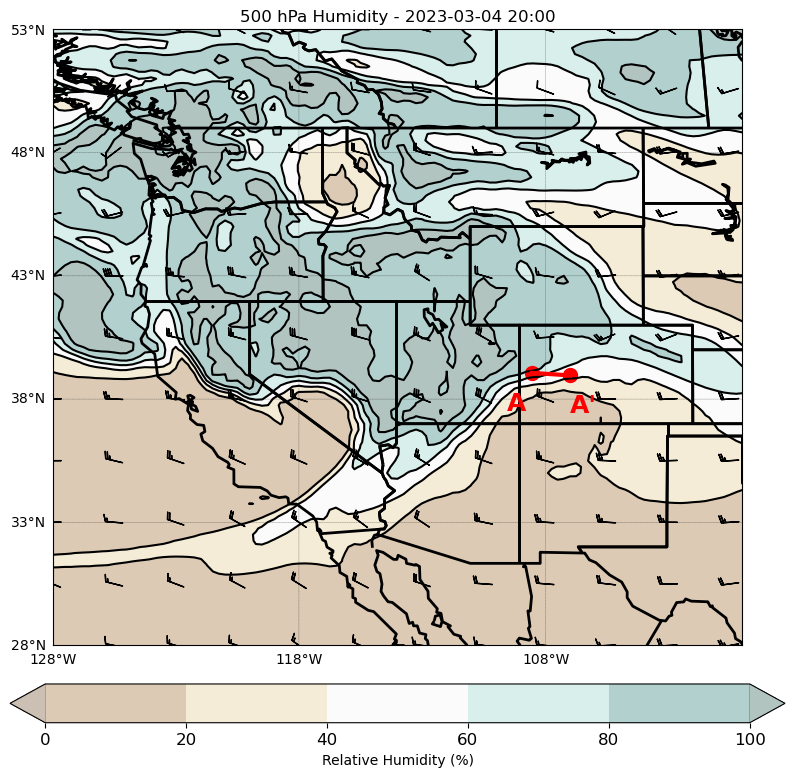

In [50]:
# create Pillow writer object
metadata = dict(title='ERA5 500 hPa Temperature', artist='DLHogan')
writer = PillowWriter(fps=3, metadata=metadata,)

# Create the figure and basemap
fig = plt.figure(figsize=(10, 10))


# with writer.saving(fig, "relative_humidity.gif", 100):
for i,t in enumerate(ds_subset_700['time'][20:21]):
    # clear the figure
    plt.clf()
    m = Basemap(projection='cyl', llcrnrlon=-128, llcrnrlat=28, urcrnrlon=-100, urcrnrlat=53, resolution='l')
    m.drawcoastlines(linewidth=2)
    m.drawcountries(linewidth=2)

    # Draw parallels and meridians
    parallels = np.arange(23, 53 + 0.25, 5)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.25)
    meridians = np.arange(-128, -100 + 0.25, 10)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.25)
    m.drawstates(linewidth=2)
    # Contour plot for temperature
    cbarticks=np.arange(0.0,100.0,10)
    cf = plt.contourf(ds_subset_700['longitude'], ds_subset_700['latitude'], (ds_subset_700['r'].sel(time=t).to_numpy()), cbarticks, cmap='BrBG', levels=np.arange(0,110,20), extend='both', alpha=0.3)
    c = plt.contour(ds_subset_700['longitude'], ds_subset_700['latitude'], (ds_subset_700['r'].sel(time=t).to_numpy()), cbarticks, levels=np.arange(0,110,20), colors='k')
    cb = fig.colorbar(cf, orientation='horizontal', pad=0.05, label='Relative Humidity (%)')
    cb.ax.tick_params(labelsize='large')
    
    # add line for the line and label A to A'
    x, y = line.xy
    m.plot(x, y, color='r', linewidth=3)
    m.scatter(gj.x, gj.y, color='r', s=100)
    m.scatter(gothic.x, gothic.y, color='r', s=100)
    plt.text(gj.x-1, gj.y-1.5, 'A', fontsize=18, color='r', fontweight='bold')
    plt.text(gothic.x, gothic.y-1.5, 'A\'', fontsize=18, color='r', fontweight='bold')

    # add title of the time
    plt.title(f'500 hPa Humidity - {ds_subset_700["time"].sel(time=t).dt.strftime("%Y-%m-%d %H:%M").item()}')
    # Add barbs for wind, showing every 10th barb
    lon, lat = np.meshgrid(ds_subset_700['longitude'], ds_subset_700['latitude'])
    m.barbs(lon[::10, ::10], lat[::10, ::10], ds_subset_700['u'][i, ::10, ::10], ds_subset_700['v'][i, ::10, ::10], length=5, pivot='middle')
    

    # writer.grab_frame()
    

# Next Process:
1) download NARR longterm mean data for u, v, q, temperature, height
2) download NARR data for 2022 and 2023. 
3) Calculate anomaly 